In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


337it [00:00, 44855.31it/s]


                0
count  568.000000
mean     0.130282
std      0.336910
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000
(454, 100, 100, 3)


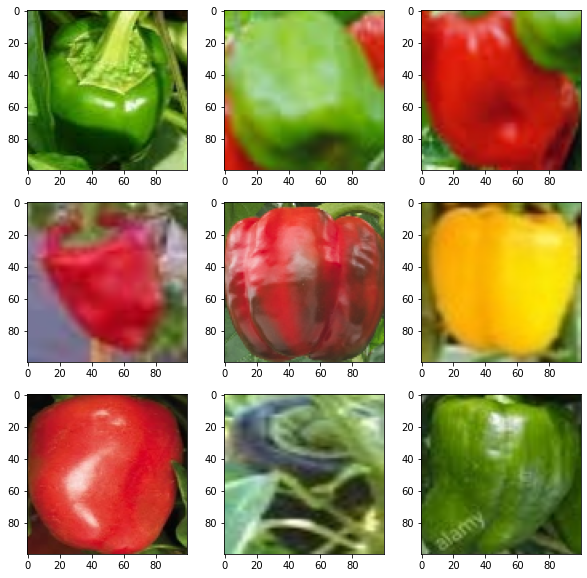

In [0]:
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import glob
import os
import json
import cv2
import random

# Shuffle files
files = []
for filepath in tqdm(glob.iglob(r'/content/drive/My Drive/Green Thumbs/bell_peppers/bell_peppers/ann/*.json')):
    files.append(filepath)
random.shuffle(files)

train_test_ratio = 0.8

images = []
labels = []

for filepath in files:
    image_path = '/content/drive/My Drive/Green Thumbs/bell_peppers/bell_peppers/img/' + os.path.basename(filepath[:-5])
    with open(filepath) as f:
        annotations = json.load(f)
        img = cv2.imread(image_path, 1)
        for obj in annotations['objects']:
            points = obj['points']['exterior']
            if not points:
              print(filepath)
            # crop out image in bounding box
            crop_img = img[points[0][1]:points[1][1], points[0][0]:points[1][0]].copy()

            # from BGR -> RGB
            crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)

            # resize to 100x100
            crop_img = cv2.resize(crop_img, (100, 100))

            # normalize pixel value -> [0, 1]
            crop_img = cv2.normalize(crop_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            
            # pixel value to type float
            crop_img = crop_img.astype('float32')

            if obj['classTitle'] == 'bell_pepper_fruit':
                images.append(crop_img)
                labels.append(0)                
            if obj['classTitle'] == 'bell_pepper_flower':
                images.append(crop_img)
                labels.append(1)

print(pd.DataFrame(labels).describe())

train_image_cnt = int(len(images) * train_test_ratio)


test_images = images[train_image_cnt:]

images = images[:train_image_cnt]
labels = labels[:train_image_cnt]

i = 0

plt.figure(figsize=(10,10))
plt.subplot(331), plt.imshow(images[i])
plt.subplot(332), plt.imshow(images[i+25])
plt.subplot(333), plt.imshow(images[i+26])
plt.subplot(334), plt.imshow(images[i+137])
plt.subplot(335), plt.imshow(images[i+50])
plt.subplot(336), plt.imshow(images[i+116])
plt.subplot(337), plt.imshow(images[i+30])
plt.subplot(338), plt.imshow(images[i+211])
plt.subplot(339), plt.imshow(images[i+160])

train_x = np.array(images)
train_y = np.array(labels)
print(train_x.shape)


In [0]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((408, 100, 100, 3), (408,)), ((46, 100, 100, 3), (46,)))

In [0]:
# converting training images into torch format
train_x = train_x.reshape(train_x.shape[0], 3, 100, 100)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([408, 3, 100, 100]), torch.Size([408]))

In [0]:
# converting validation images into torch format
val_x = val_x.reshape(val_x.shape[0], 3, 100, 100)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([46, 3, 100, 100]), torch.Size([46]))

In [0]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(8),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(8, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(144, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [0]:
# defining the model
model = Net()
# defining the optimizer
# Adam leverages the power of adaptive learning rates methods to find individual learning rates for each parameter. 
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function

criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_run

In [0]:
def train(epoch):
    model.train()
    tr_loss = 0
    
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)
        
# defining the number of epochs
n_epochs = 80
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(2.7390, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  3 	 loss : tensor(2.0317, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  5 	 loss : tensor(0.1755, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  7 	 loss : tensor(0.1298, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  9 	 loss : tensor(0.0899, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  11 	 loss : tensor(0.1065, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  13 	 loss : tensor(0.0853, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  15 	 loss : tensor(0.0634, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  17 	 loss : tensor(0.0612, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  19 	 loss : tensor(0.0546, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  21 	 loss : tensor(0.0535, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  23 	 loss : tensor(0.0590, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  25 	 loss : tensor(0.0554, device='c

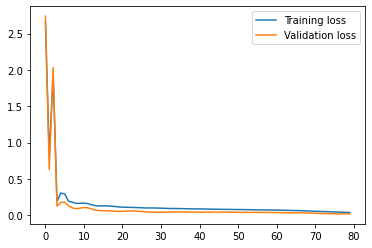

In [0]:
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [0]:
# prediction for training set
with torch.no_grad():
    output = model(train_x.cuda())
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
accuracy_score(train_y, predictions)

0.9926470588235294

In [0]:
# prediction for validation set
with torch.no_grad():
    output = model(val_x.cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
accuracy_score(val_y, predictions)

1.0

In [0]:
# converting the list to numpy array
test_x = np.array(test_images)
test_x.shape

(114, 100, 100, 3)

In [0]:
# converting training images into torch format
test_x = test_x.reshape(len(test_images), 3, 100, 100)
test_x  = torch.from_numpy(test_x)
test_x.shape

torch.Size([114, 3, 100, 100])

In [0]:
# generating predictions for test set
with torch.no_grad():
    output = model(test_x.cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
print(predictions[-9:])


[0 1 0 0 0 0 0 0 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


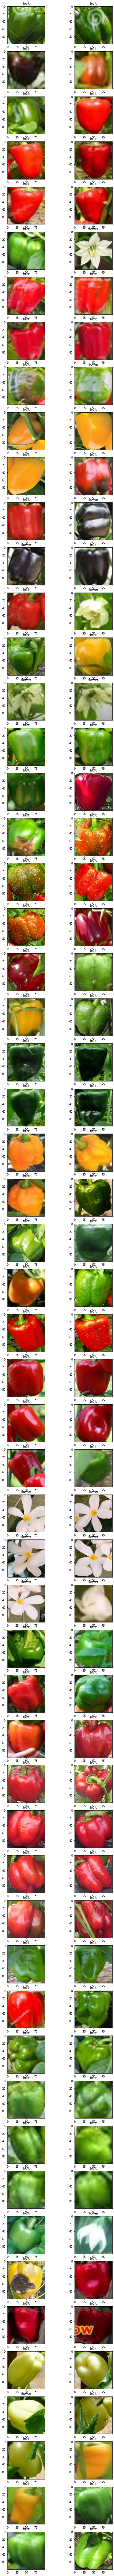

In [0]:
column_size = 2
row_size = int(len(test_images) / column_size + 1)

fig = plt.figure(figsize=(8,row_size * 3))

for i, test_image in enumerate(test_images):
    sp = plt.subplot2grid((row_size, column_size), (i // column_size,i % column_size))
    sp.title.set_text('flower' if predictions[i] == 1 else 'fruit')
    sp.imshow(test_images[i])

plt.show()